In [2]:
import aocd
from aocd.models import Puzzle
day = 20
year = 2020
puzzle = Puzzle(year=year, day=day)
# data = aocd.get_data(day=day, year=year)
with open('./data/input_{:02d}'.format(day), 'w') as fh:
    fh.write(puzzle.input_data)

In [568]:
import matplotlib.pyplot as plt

In [569]:
%matplotlib inline

In [3]:
data = puzzle.input_data.splitlines()
data[:10]

['Tile 3593:',
 '#..#.##...',
 '.#..#.#...',
 '.#####..#.',
 '.......#.#',
 '#...#.....',
 '..#.....##',
 '.#....#...',
 '.#..#.....',
 '..#......#']

In [14]:
test_data = """Tile 2311:
..##.#..#.
##..#.....
#...##..#.
####.#...#
##.##.###.
##...#.###
.#.#.#..##
..#....#..
###...#.#.
..###..###

Tile 1951:
#.##...##.
#.####...#
.....#..##
#...######
.##.#....#
.###.#####
###.##.##.
.###....#.
..#.#..#.#
#...##.#..

Tile 1171:
####...##.
#..##.#..#
##.#..#.#.
.###.####.
..###.####
.##....##.
.#...####.
#.##.####.
####..#...
.....##...

Tile 1427:
###.##.#..
.#..#.##..
.#.##.#..#
#.#.#.##.#
....#...##
...##..##.
...#.#####
.#.####.#.
..#..###.#
..##.#..#.

Tile 1489:
##.#.#....
..##...#..
.##..##...
..#...#...
#####...#.
#..#.#.#.#
...#.#.#..
##.#...##.
..##.##.##
###.##.#..

Tile 2473:
#....####.
#..#.##...
#.##..#...
######.#.#
.#...#.#.#
.#########
.###.#..#.
########.#
##...##.#.
..###.#.#.

Tile 2971:
..#.#....#
#...###...
#.#.###...
##.##..#..
.#####..##
.#..####.#
#..#.#..#.
..####.###
..#.#.###.
...#.#.#.#

Tile 2729:
...#.#.#.#
####.#....
..#.#.....
....#..#.#
.##..##.#.
.#.####...
####.#.#..
##.####...
##..#.##..
#.##...##.

Tile 3079:
#.#.#####.
.#..######
..#.......
######....
####.#..#.
.#...#.##.
#.#####.##
..#.###...
..#.......
..#.###..."""

In [137]:
import numpy as np
from collections import defaultdict
from functools import reduce
from operator import mul

In [199]:
direction = {
    'left': 0,
    'top': 1,
    'right': 2,
    'down': 3
}

rv_dir = {v: k for k, v in direction.items()}

In [526]:
shape = (10, 10)

def parse(data):
    tiles = {}
    idx = None    
    y = 0
    for line in data:
        if line.strip() == "":
            continue
        if line.startswith('Tile'):
            if idx is not None:
                tiles[idx] = tile.copy()
            tile = np.zeros(shape, dtype=np.int8)
            idx = int(line.split('Tile ')[1][:-1])
            y = 0
        else:
            tile[y, :] = np.array([1 if c == '#' else 0 for c in line])
            y += 1
    tiles[idx] = tile.copy()
    return tiles

def get_border(tile):
    res = []
    border = tuple(tile[:, 0])
    res.append(border)

    border = tuple(tile[0, :])
    res.append(border)

    border = tuple(tile[:, -1])
    res.append(border)        

    border = tuple(tile[-1, :])
    res.append(border)
    return res
    

def get_borders(tiles):
    borders = defaultdict(list)
    for idx in tiles.keys():
        borders[idx] =  get_border(tiles[idx])   
    return borders

def flip(idx):
    return [tuple(side[::-1]) for side in borders[idx]][::-1]

def fliplr(idx):
    tiles[idx] = np.fliplr(tiles[idx])
    return get_border(tiles[idx])

def flipud(idx):
    tiles[idx] = np.flipud(tiles[idx])
    return get_border(tiles[idx])

def rot90(idx):
    tiles[idx] = np.rot90(tiles[idx])
    return get_border(tiles[idx])


def flip_axis(idx, axis=0):
    sides = borders[idx]
    if axis == 0:
        return [
            sides[0][::-1],
            sides[3],
            sides[2][::-1],
            sides[1]
        ]
    else:
        return [
            sides[2],
            sides[1][::-1],
            sides[0],
            sides[3][::-1]
        ]

def rotate(idx):
    return borders[idx][-1:] + borders[idx][:-1]

def lineUp(id1, id2):
    left = set(borders[id1])
    return (left & set(borders[id2])), (left & set(flip(id2)))

def lineUpB(id1, id2):
    left = set(borders[id1])
    match = (left & set(borders[id2]))
    if len(match):
        match = match.pop()
        left_idx = borders[id1].index(match)
        right_idx = borders[id2].index(match)
        num_rot = (right_idx - left_idx + 2) % 4
        return (match, num_rot, left_idx, None)
    match = (left & set(flip(id2)))
    if len(match):    
        match = match.pop()
        left_idx = borders[id1].index(match)
        right_idx = borders[id2].index(match[::-1])
        num_rot = (right_idx - left_idx + 2) % 4
        if (rv_dir[left_idx] in ('left', 'right')):
            return (match, num_rot, left_idx, 'ud')
        else:
            return (match, num_rot, left_idx, 'lr')
    raise(Exception())

def get_neighbors(tiles):
    nbrs = defaultdict(list)
    for tileA in tiles:
        for tileB in tiles:
            if tileA == tileB:
                continue
            non_flipped, flipped = lineUp(tileA, tileB)
            if len(non_flipped) or len(flipped):
                nbrs[tileA].append(tileB)
    return nbrs

In [527]:
# tiles = parse(test_data.splitlines())
tiles = parse(puzzle.input_data.splitlines())
borders = get_borders(tiles)
nbrs = get_neighbors(tiles)

corners = []
for tile in nbrs:
    if len(nbrs[tile]) == 2:
        corners.append(tile)
        print(tile, nbrs[tile])

2221 [2381, 2309]
3011 [2543, 2699]
2251 [3613, 2711]
1847 [3853, 1123]


In [330]:
prod = reduce(mul, corners)
prod

27803643063307

In [331]:
corners

[2221, 3011, 2251, 1847]

In [151]:
puzzle.answer_a = prod

You don't seem to be solving the right level.  Did you already complete it? [Return to Day 20]


In [186]:
# Part B

In [528]:
def get_coords(old, where):
    x, y = old
    where = rv_dir[where]
    if where == 'right':
        x += 1
    elif where == 'left':
        x -= 1
    elif where == 'down':
        y += 1
    else:
        y -= 1
    if x < 0:
        print(old, where)
        raise
    if y < 0:
        print(old, where)
        raise
    return x, y

In [529]:
sea_monster = """                  # 
#    ##    ##    ###
 #  #  #  #  #  #   """

In [610]:
# tiles = parse(test_data.splitlines())
tiles = parse(puzzle.input_data.splitlines())
borders = get_borders(tiles)
nbrs = get_neighbors(tiles)
dim = int(math.sqrt(len(tiles)))

corners = []
for tile in nbrs:
    if len(nbrs[tile]) == 2:
        corners.append(tile)
        print(tile, nbrs[tile])

2221 [2381, 2309]
3011 [2543, 2699]
2251 [3613, 2711]
1847 [3853, 1123]


In [611]:
# building the image
grid = np.zeros((dim,dim), dtype=np.int16)
start = corners[0]
grid[0, 0] = start
location = {start: (0, 0)}
placed = set([start])
queue = [start]

# orient the corner tile
right, down = nbrs[start]

# rotate until nbr to the right can be lined up
nfl, fl = lineUp(start, right)
match = nfl.pop() if len(nfl) else fl.pop()
for i in range((borders[start].index(match) - direction['right']) % 4):
    borders[start] = rot90(start)
    
# flip if nbrs cannot be lined up at bottom
nfl, fl = lineUp(start, down)
match = nfl.pop() if len(nfl) else fl.pop()
if not borders[start].index(match) == direction['down']:
    borders[start] = flipud(start)
#     borders[start] = rotate(start)
    
while queue:
    nxt = queue.pop(0)
#     print(nxt, nbrs[nxt])
    for nbr in nbrs[nxt]:

        if nbr in placed:
            continue
        match, num_rot, where, doflip = lineUpB(nxt, nbr)
#         print("#", nxt, nbr, rv_dir[where], doflip, match, num_rot, where, doflip)
        for i in range(num_rot):
            borders[nbr] = rot90(nbr)
        match, num_rot, where, doflip = lineUpB(nxt, nbr)
        if num_rot != 0:
            raise
            print("!!!", num_rot, nbr, doflip)
        if doflip == 'ud':
            borders[nbr] = flipud(nbr)
        elif doflip == 'lr':
            borders[nbr] = fliplr(nbr)
        
#         print("@", nxt, nbr, rv_dir[where], doflip, match, num_rot, where, doflip)
        new_x, new_y = get_coords(location[nxt], where)
        
#         print(nbr, rv_dir[where], (new_x, new_y), doflip)
        grid[new_y, new_x] = nbr
        placed.add(nbr)
        location[nbr] = (new_x, new_y)
        queue.append(nbr)

In [612]:
grid

array([[2221, 2381, 3449, 3407, 3643, 1097, 2203, 1321, 1447, 1087, 2711,
        2251],
       [2309, 1997, 1237, 2677, 3917, 2803, 3529, 2693, 3299, 3061, 1873,
        3613],
       [3191, 3947, 1307, 1597, 3001, 1201, 1637, 2161, 1987, 2833, 2659,
        2593],
       [1669, 2753, 1721, 1019, 1129, 2657, 1381, 1181, 3833, 3637, 2687,
        3089],
       [2399, 1187, 1613, 2281, 2851, 2539, 3881, 1061, 3049, 3467, 3863,
        3319],
       [3461, 3361, 2237, 2131, 3709, 3793, 3229, 2837, 1223, 3607, 1291,
        1063],
       [2137, 2939, 2377, 2069, 3373, 1801, 1051, 3697, 2819, 2293, 3019,
        1931],
       [2113, 3739, 2087, 3251, 2957, 3631, 3163, 2273, 2861, 2333, 1951,
        1259],
       [1567, 2239, 1171, 1433, 2027, 2083, 1091, 2389, 3499, 3343, 1559,
        3331],
       [1163, 1823, 3593, 2467, 2617, 1373, 2843, 3533, 2411, 3371, 3203,
        3079],
       [1123, 2903, 3067, 2897, 3797, 3989, 3517, 3617, 3929, 1487, 1831,
        2543],
       [1847, 3853, 1

In [613]:
grid.shape

(12, 12)

In [614]:
tile_dim = shape[0]-2
image_shape = (tile_dim * dim, tile_dim * dim)
image = np.zeros(image_shape, dtype=np.int8)

for i in range(dim):
    for j in range(dim):
        from_i = i * tile_dim
        to_i = (i+1) * tile_dim
        from_j = j * tile_dim
        to_j = (j+1) * tile_dim
        
        image[from_j:to_j, from_i:to_i] = tiles[grid[j, i]][1:-1, 1:-1]

In [615]:
image.shape

(96, 96)

In [616]:
def parse_monster(data):
    monster = np.zeros((len(data), len(data[0])), dtype=np.int8)
    y=0
    for line in data:
        monster[y, :] = np.array([1 if c == '#' else 0 for c in line])
        y += 1
    return monster

def get_orientations(ndarray):
    for j in range(2):
        for i in range(4):
            ndarray = np.rot90(ndarray)
            yield ndarray
        ndarray = np.flipud(ndarray)

In [617]:
monster = parse_monster(sea_monster.splitlines())

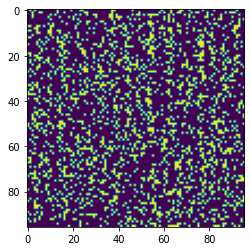

In [618]:
plt.imshow(image)

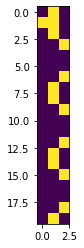

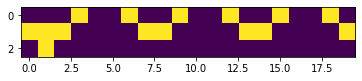

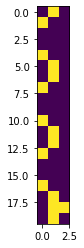

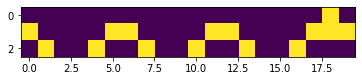

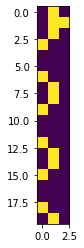

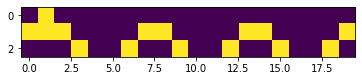

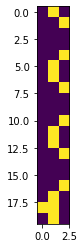

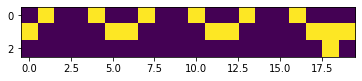

In [619]:
for im in get_orientations(monster):
    plt.imshow(im)
    plt.show()

In [620]:
mshape = monster.shape
nmonster = monster.sum()
found = False
for mon in get_orientations(monster):
    mshape = mon.shape
    for i in range(0, image_shape[1] - mshape[1]):
        for j in range(0, image_shape[0] - mshape[0]):
            hits = mon & image[j:j+mshape[0], i:i+mshape[1]]
#             print(hits.sum())
            if (hits.sum() == nmonster):
                found = True
                image[j:j+mshape[0], i:i+mshape[1]] += 2* mon
                print(j, i)
    if found:
        
        break
#         print(monster & image[j:j+mshape[0], i:i+mshape[1]])

71 2
7 3
32 3
65 7
21 8
43 13
15 14
70 15
55 21
18 24
60 27
26 31
57 32
2 36
70 37
42 38
7 42
30 43
52 46
23 47
34 52
5 53
70 54
58 59
35 61
8 62
67 65
23 69
60 70
40 74
13 75
63 76
10 80
58 80
16 85
67 86
8 90


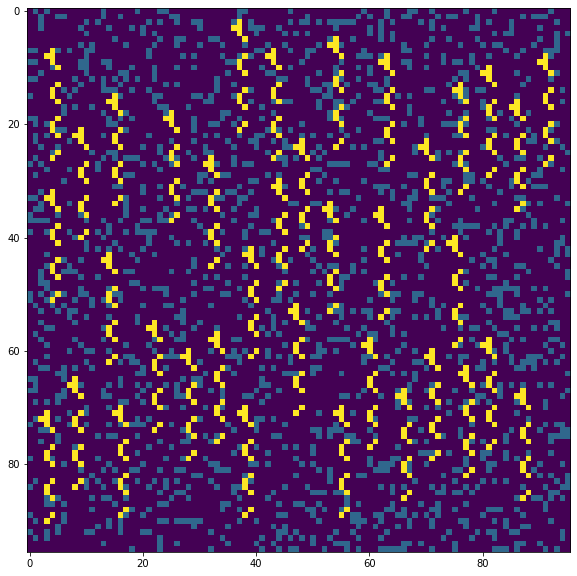

In [624]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.imshow(image)

In [622]:
(image == 1).sum()

1644

In [623]:
puzzle.answer_b = _

--- Day 20: Jurassic Jigsaw ---The high-speed train leaves the forest and quickly carries you south. You can even see a desert in the distance! Since you have some spare time, you might as well see if there was anything interesting in the image the Mythical Information Bureau satellite captured.
After decoding the satellite messages, you discover that the data actually contains many small images created by the satellite's camera array. The camera array consists of many cameras; rather than produce a single square image, they produce many smaller square image tiles that need to be reassembled back into a single image.
Each camera in the camera array returns a single monochrome image tile with a random unique ID number.  The tiles (your puzzle input) arrived in a random order.
Worse yet, the camera array appears to be malfunctioning: each image tile has been rotated and flipped to a random orientation. Your first task is to reassemble the original image by orienting the tiles so they fit